In [1]:
!pip install torchsde

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
import numpy as np
import torch
import torch.optim.swa_utils as swa_utils
import torchsde
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class LipSwish(torch.nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()

        model = [torch.nn.Linear(in_size, mlp_size), LipSwish()]
        
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(LipSwish())
        
        model.append(torch.nn.Linear(mlp_size, out_size))
       
        if tanh:
            model.append(torch.nn.Tanh())
       
        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

Consider

$$dX_t = (A_tX_t + B_tα_t)dt + \sigma_t dW_t, \quad X_0=x_0$$

Parameterize the control $\alpha$ as the output of a Neural CDE driven by $X$

$$\alpha_t = h_\theta(t,z_t) \quad dz_t = f_\theta(t,z_t)dX_t, \quad z_0 = g_\theta(x_0)$$

where $h_\theta, f_\theta, g_\theta$ are feedforward neural networks.

We rewrite the two equations 

$$dX_t = (A_tX_t + B_t h_\theta(t,z_t))dt + \sigma_t dW_t, \quad X_0 = x_0$$

$$dz_t = f_\theta(t,z_t)(A_tX_t + B_t h_\theta(t,z_t))dt + f_\theta(t,z_t) \sigma_t dW_t, \quad z_0 = g_\theta(x_0)$$

This gives a single SDE with augmented state variable $Y_t = (X_t, z_t)$. 

We then solve the optimisation 

$$\min_\theta \mathbb{E}\left[ \int_0^T((X_t)^TQ_tX_t + α_t^TR_tα_t)dt + (X_T)^TQ_TX_T) \right]$$

Here, I calculate the integral $\int_0^T((X_t)^TQ_tX_t + α_t^TR_tα_t)dt$ as :
$$ ∑^i \left[ [(X_i)^TQ_iX_i + α_i^TR_iα_i]*Δt \right]; \quad i = 0,Δt,2Δt,...,T $$ 

and the $α_i$ is calculated by $\alpha_t = h_\theta(t,z_t)$.

And I write the code for one-dimensional LQ problem, with parameters:

$$A_t = 0; \quad σ_t = σ; \quad B_t=R_t=1;\quad Q_t = 0,for\quad t\in [0,T); \quad $$
and where $ x_0,σ,Q_T>=0$ is given.


In [5]:
class SDEFunc(torch.nn.Module):
    sde_type = 'ito'
    noise_type = 'general'

    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t):
        super().__init__()

        self.A_t, self.sigma_t, self.B_t = A_t, sigma_t, B_t

        self.hidden_size = hidden_size

        self.f_theta = MLP(1 + hidden_size, hidden_size * 1, mlp_size, num_layers, tanh=True)

        self.h_theta = MLP(1 + hidden_size, 1, mlp_size, num_layers, tanh=True)

    def f_and_g(self, t, y):
        # t has shape ()
        # y has shape (batch_size, 1 + hidden_size) --- this is the augmented(input) variable (log_s, z)

        t = t.expand(y.size(0), 1)

        x = y[:,0].unsqueeze(1) # log(S)
        
        z = y[:,1:] 
        
        tz = torch.cat([t, z], dim=1)
        
        h_tz = self.h_theta(tz)
        h_tz_z = h_tz*x

        f_tz = self.f_theta(tz)
        # f_tz = 1e-8*self.f_theta(tz)
        stand = torch.tensor([1])
        stand_= stand.repeat(batch_size, 1)

        drift_x = (self.A_t*x + self.B_t*h_tz_z)
        drift_z = f_tz*drift_x
        drift = torch.cat([drift_x, drift_z], dim=1)

        diffusion_x = self.sigma_t*stand_
        diffusion_z = f_tz*diffusion_x
        diffusion = torch.cat([diffusion_x, diffusion_z], dim=1).view(x.shape[0], 1 + self.hidden_size, 1)
        
        return drift, diffusion

In [6]:
class SDE(torch.nn.Module):
    def __init__(self, hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt):
        super().__init__()
        self.g_theta = MLP(1, hidden_size, mlp_size, num_layers, tanh=True)
        self._func = SDEFunc(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t)
        self.dt = dt

    def forward(self, x0, ts):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.
        y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
        # y0 = torch.cat([x0, self.g_theta(x0)], dim=1)
    

        ys = torchsde.sdeint(self._func, y0, ts, method='euler', dt=self.dt, adaptive=False) 
    
        # normalize the data
        # y0_flat = ys[0].view(-1)
        # ys = (ys - y0_flat.mean()) / y0_flat.std()

        return ys.permute(1,0,2)

In [7]:
def results_plot(model, x0_batch, losses, controls, T, batch_size, len, v_list, a_list, times):

    ts_ = torch.linspace(0, T, len, device=device)
    t = ts_.repeat(batch_size, 1).unsqueeze(2)

    with torch.no_grad():

        generated_samples = model(x0_batch, ts_)

        t = ts_.expand(batch_size, len).unsqueeze(2)
        x = generated_samples[...,0].unsqueeze(2)
        z = generated_samples[...,1:]  
        tz = torch.cat([t, z], dim=2)

#         alpha = model._func.h_theta(tz).cpu().numpy() 
        
        out_ = model._func.h_theta(tz).cpu()
        alpha = (out_[0,:,0]*x[0,:,0]).unsqueeze(1)
        alpha = torch.permute(alpha, (1,0))

        for i in range(1, batch_size):
          product_ = (out_[i,:,0]*x[i,:,0]).unsqueeze(1)
          product_ = torch.permute(product_, (1,0))
          alpha = torch.cat([alpha, product_], dim=0) 

        alpha = alpha.unsqueeze(2)
        
        
      
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        for k in range(batch_size):
            ax[0].plot(x[k,:,0], alpha=0.1, c='red')
            ax[0].set_title('Process $X_t$')
            ax[1].plot(alpha[k,:,0], alpha=0.1, c='blue')
            ax[1].set_title('Control $A_t$')
        ax[2].plot(torch.tensor(losses).cpu().numpy())
        ax[2].plot(v_list, 'r--')
        ax[2].set_title(f'v(t=0, x={x0})')
        ax[3].plot(torch.tensor(controls).cpu().numpy())
        ax[3].plot(a_list, 'r--')
        ax[3].set_title(f'at time 0:control(t=0, x={x0})')
        plt.show()

In [8]:
# Architectural hyperparameters. 
hidden_size = 1
mlp_size = 1
num_layers = 2

# rescaling constants
scale_lift = 1e-8
scale_vec_fields = 1e-8
scale_readout_weight = 1e-8
scale_readout_bias = 1e0

# parameters of dynamics
sigma = 0.1
# those parameters can be vectors
A_t = 0
sigma_t = sigma
B_t = 1
Q_t = 0
Q_T = 1
R_t = 1

T = 0.1
dt = 0.001
# T = 1
# dt = 0.01



# Training hyperparameters. 
lr = 1e-2
# lr = 1            
weight_decay = 1e-2
batch_size = 500        
t_size = 100
t_size_test = 100
# iterations = 10000  
# iterations_per_print = 100
iterations = 500  
iterations_per_print = 10
times = int(iterations/iterations_per_print)

In [9]:
model = SDE(hidden_size, mlp_size, num_layers, A_t, sigma_t, B_t, dt).to(device)

In [10]:
model

SDE(
  (g_theta): MLP(
    (_model): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=True)
      (1): LipSwish()
      (2): Linear(in_features=1, out_features=1, bias=True)
      (3): LipSwish()
      (4): Linear(in_features=1, out_features=1, bias=True)
      (5): Tanh()
    )
  )
  (_func): SDEFunc(
    (f_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
    (h_theta): MLP(
      (_model): Sequential(
        (0): Linear(in_features=2, out_features=1, bias=True)
        (1): LipSwish()
        (2): Linear(in_features=1, out_features=1, bias=True)
        (3): LipSwish()
        (4): Linear(in_features=1, out_features=1, bias=True)
        (5): Tanh()
      )
    )
  )
)

In [11]:
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
# optimiser = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=weight_decay) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=.999)
ts = torch.linspace(0, T, t_size, device=device)
losses = []
controls = []

  0%|                                                   | 0/500 [00:00<?, ?it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 23.25 
 theoretical optimal control at time 0: -4.55


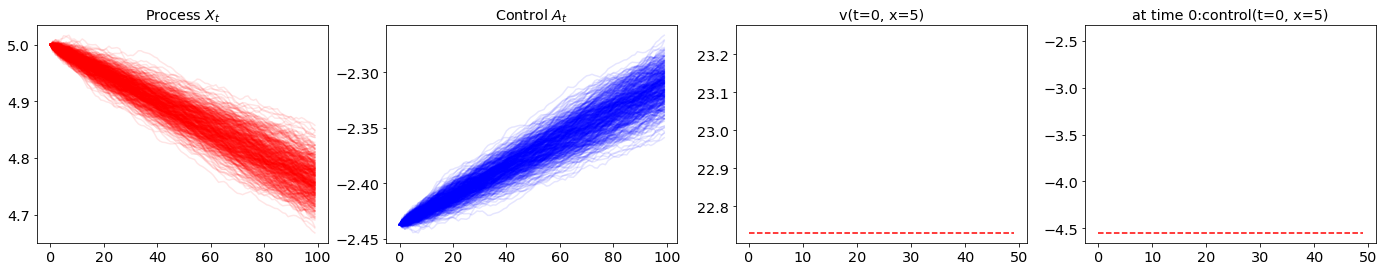

  2%|▊                                         | 10/500 [00:03<01:33,  5.25it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 23.04 
 theoretical optimal control at time 0: -4.55


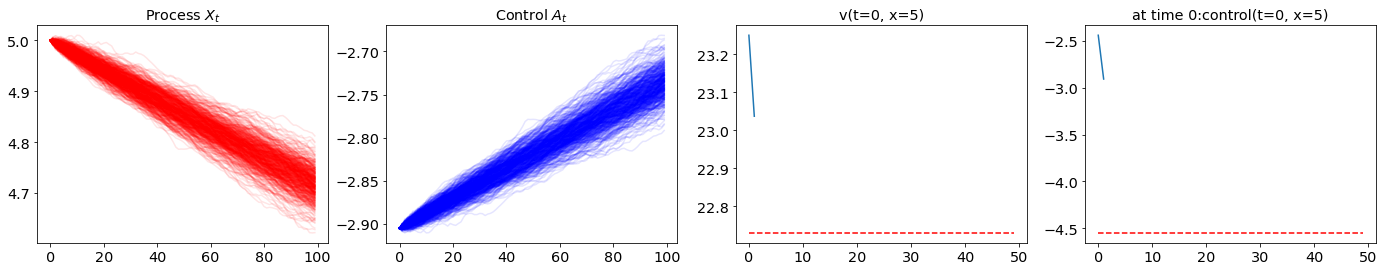

  4%|█▋                                        | 20/500 [00:06<01:29,  5.38it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.94 
 theoretical optimal control at time 0: -4.55


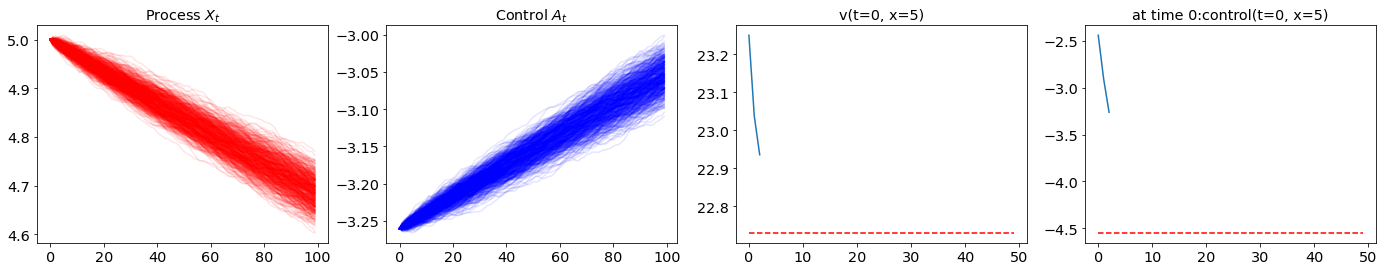

  6%|██▌                                       | 30/500 [00:09<01:23,  5.61it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.88 
 theoretical optimal control at time 0: -4.55


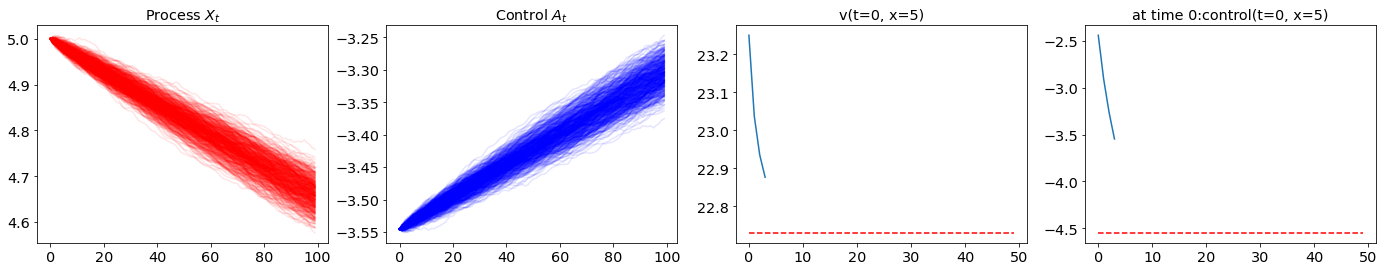

  8%|███▎                                      | 40/500 [00:12<01:25,  5.40it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.81 
 theoretical optimal control at time 0: -4.55


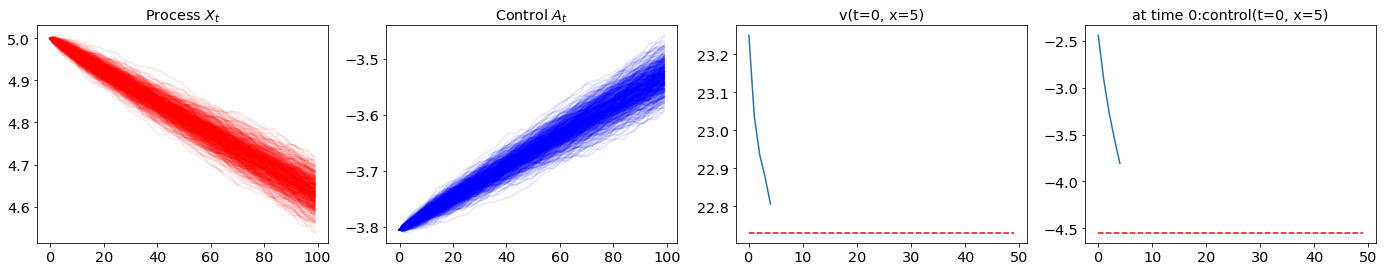

 10%|████▏                                     | 50/500 [00:15<01:25,  5.23it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.77 
 theoretical optimal control at time 0: -4.55


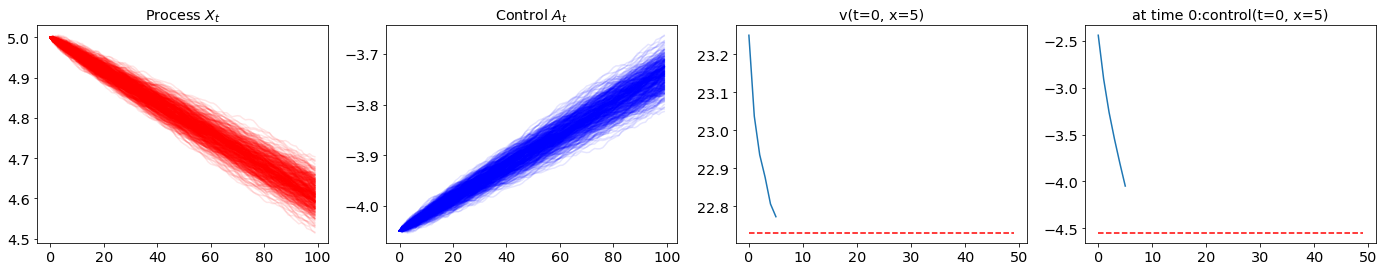

 12%|█████                                     | 60/500 [00:18<01:24,  5.23it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


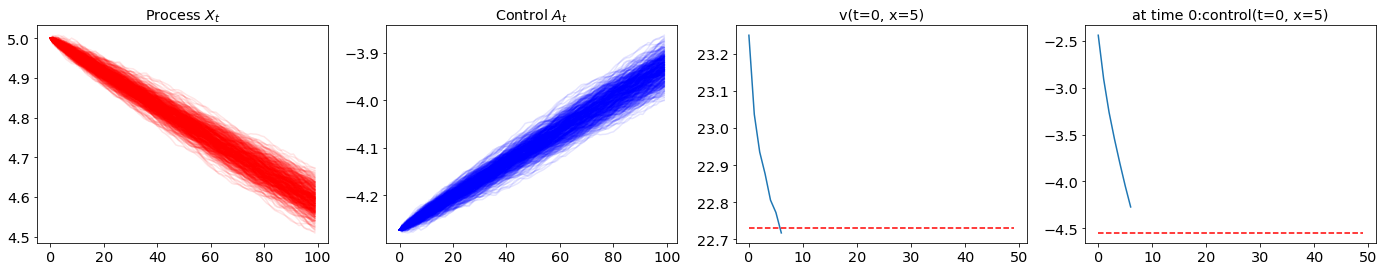

 14%|█████▉                                    | 70/500 [00:21<01:21,  5.25it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


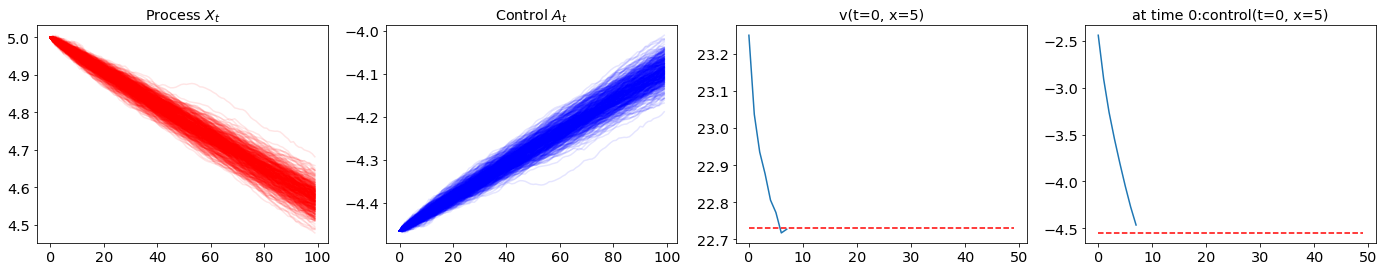

 16%|██████▋                                   | 80/500 [00:24<01:20,  5.24it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


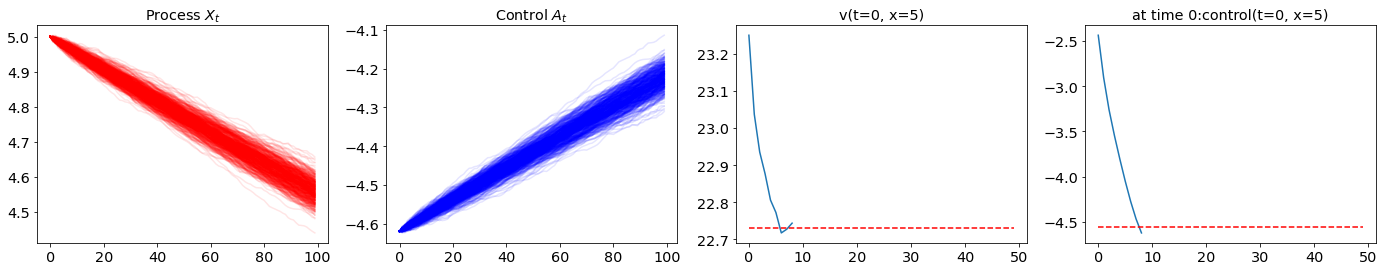

 18%|███████▌                                  | 90/500 [00:27<01:18,  5.23it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


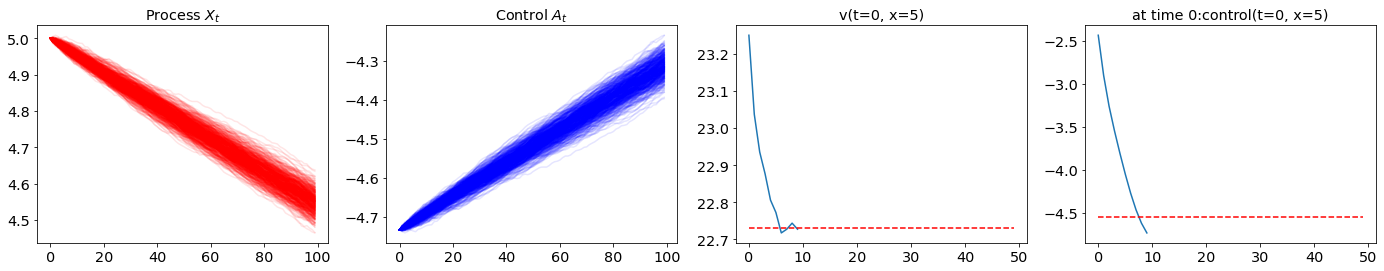

 20%|████████▏                                | 100/500 [00:30<01:16,  5.21it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.77 
 theoretical optimal control at time 0: -4.55


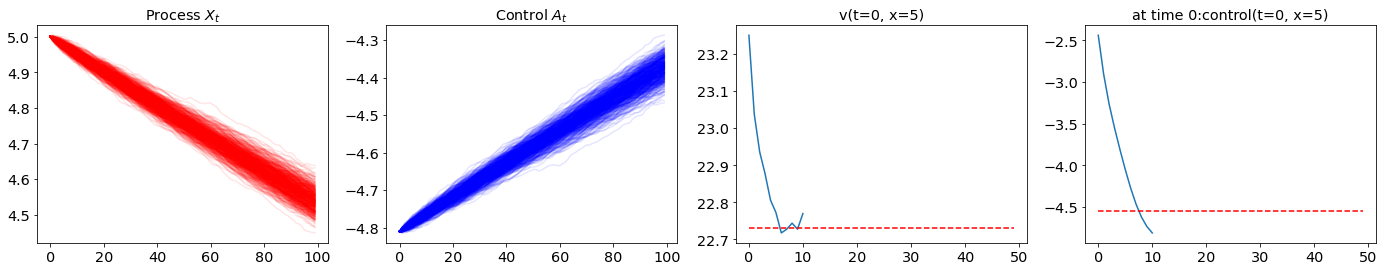

 22%|█████████                                | 110/500 [00:33<01:09,  5.60it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


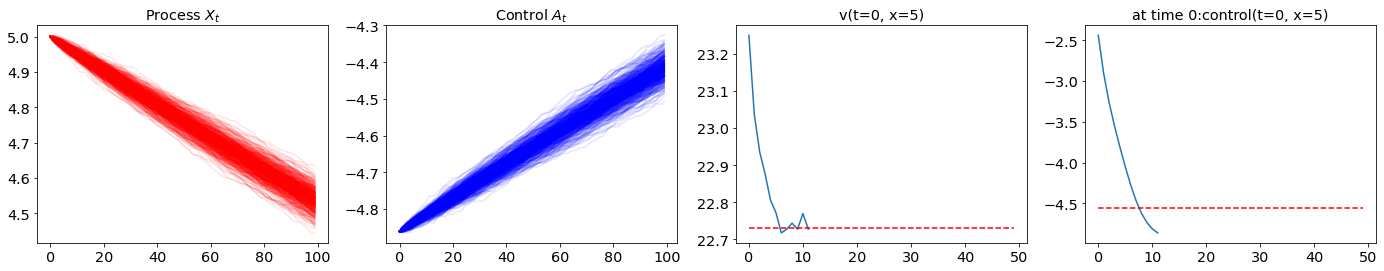

 24%|█████████▊                               | 120/500 [00:35<01:07,  5.64it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


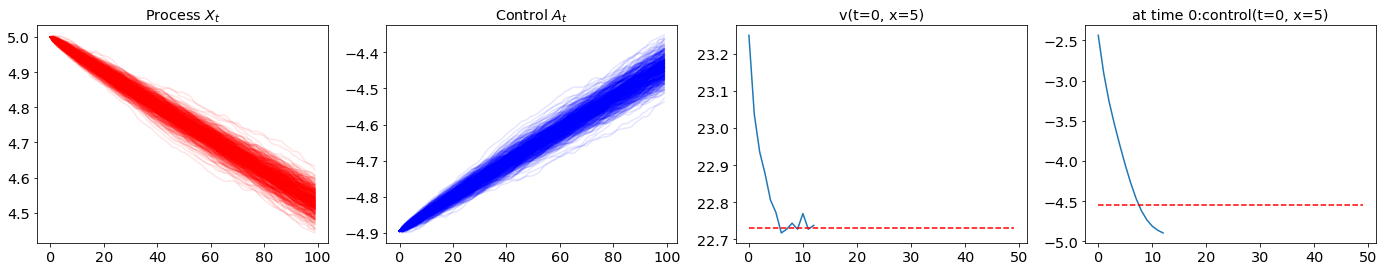

 26%|██████████▋                              | 130/500 [00:38<01:05,  5.68it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


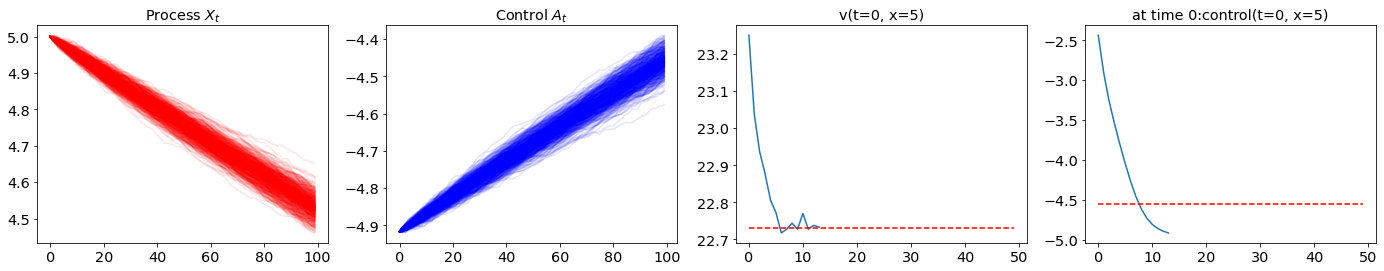

 28%|███████████▍                             | 140/500 [00:41<01:08,  5.25it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.71 
 theoretical optimal control at time 0: -4.55


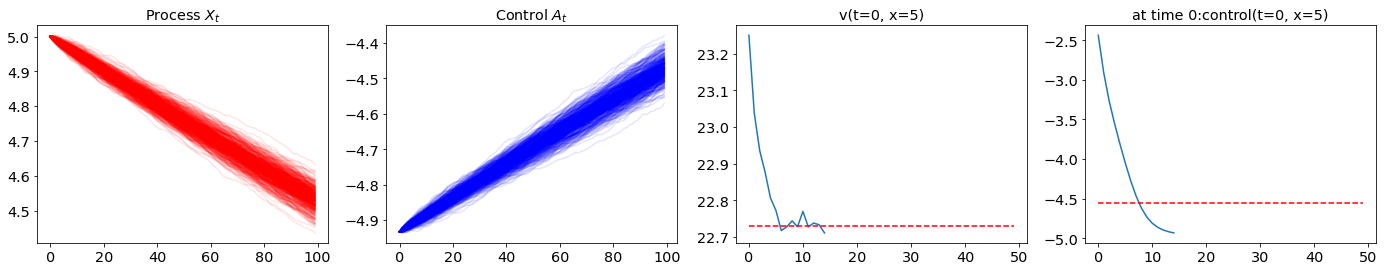

 30%|████████████▎                            | 150/500 [00:44<01:05,  5.37it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


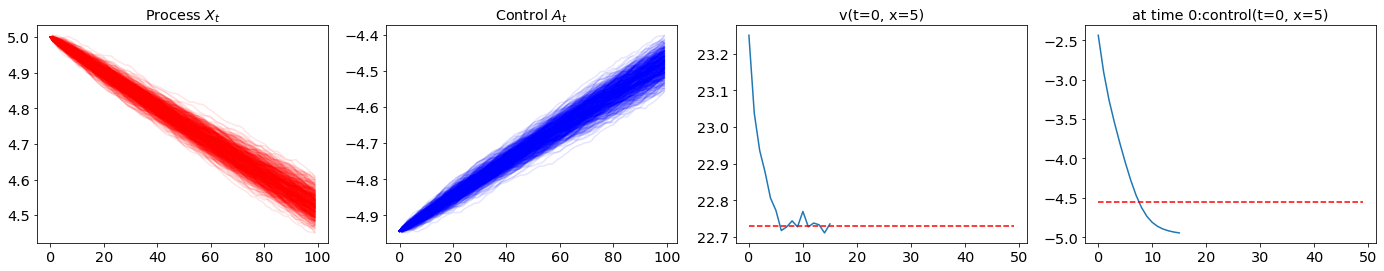

 32%|█████████████                            | 160/500 [00:47<01:03,  5.37it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


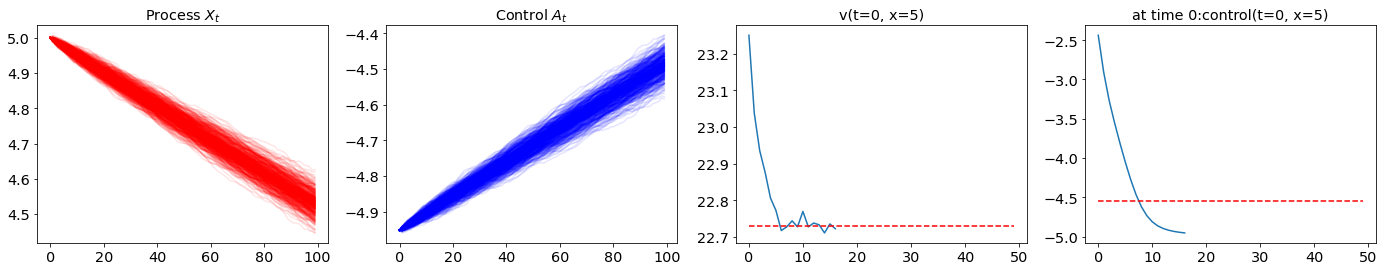

 34%|█████████████▉                           | 170/500 [00:50<01:02,  5.27it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


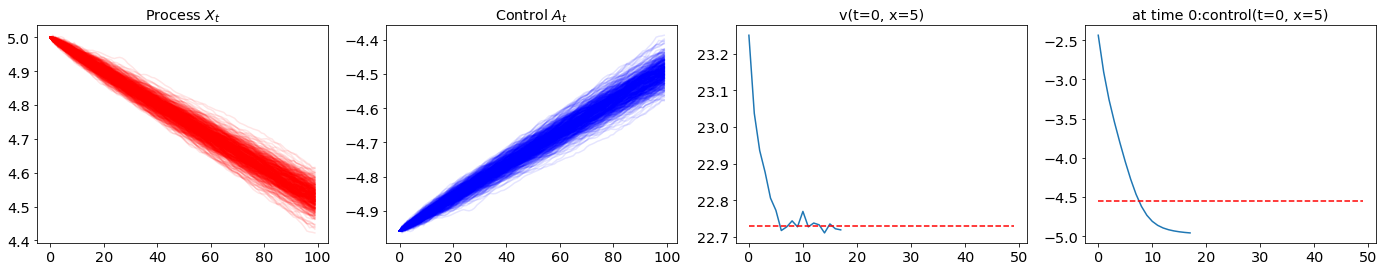

 36%|██████████████▊                          | 180/500 [00:53<00:57,  5.60it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.71 
 theoretical optimal control at time 0: -4.55


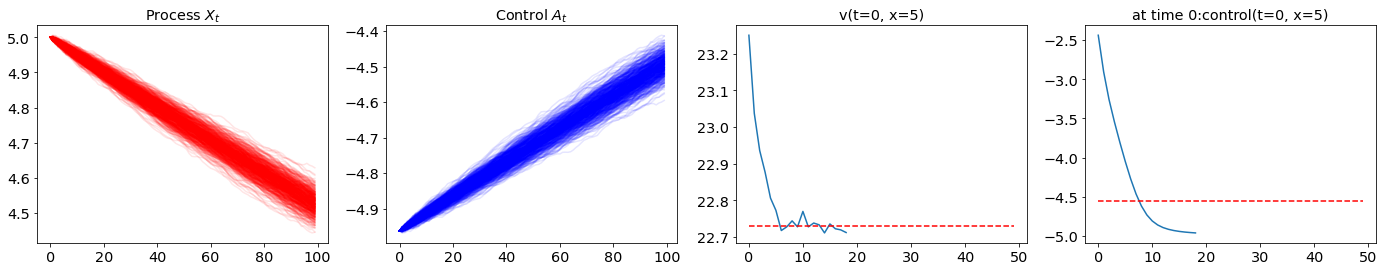

 38%|███████████████▌                         | 190/500 [00:56<00:55,  5.62it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.71 
 theoretical optimal control at time 0: -4.55


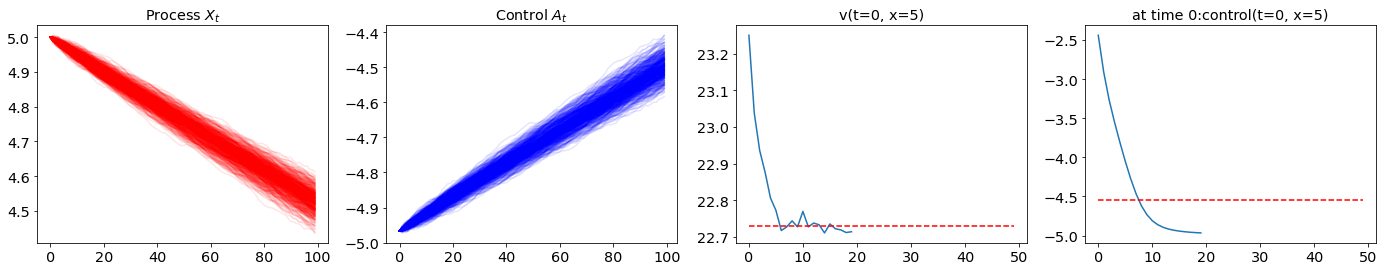

 40%|████████████████▍                        | 200/500 [00:59<00:52,  5.68it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


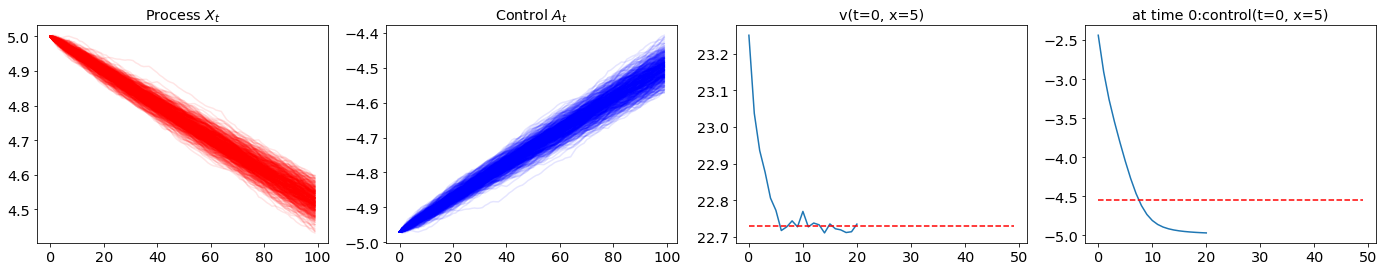

 42%|█████████████████▏                       | 210/500 [01:02<00:51,  5.67it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.71 
 theoretical optimal control at time 0: -4.55


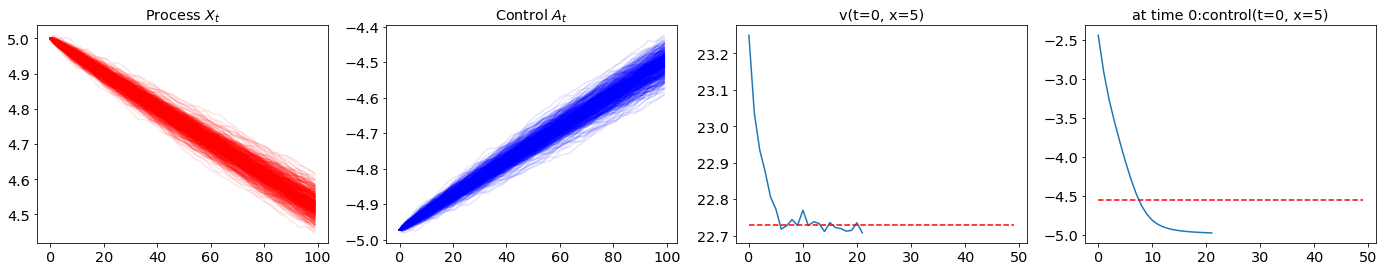

 44%|██████████████████                       | 220/500 [01:04<00:49,  5.64it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


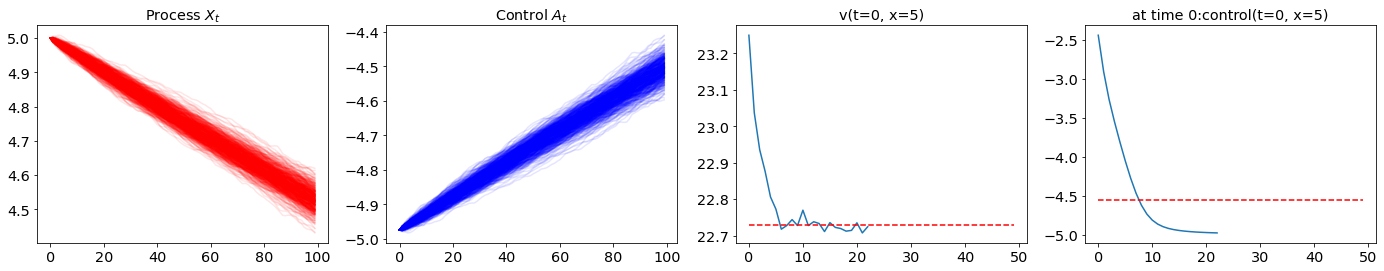

 46%|██████████████████▊                      | 230/500 [01:07<00:49,  5.47it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


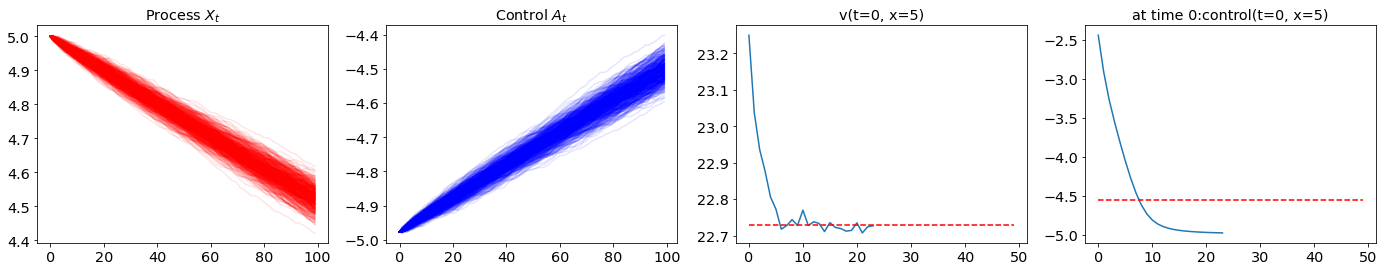

 48%|███████████████████▋                     | 240/500 [01:10<00:47,  5.48it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.75 
 theoretical optimal control at time 0: -4.55


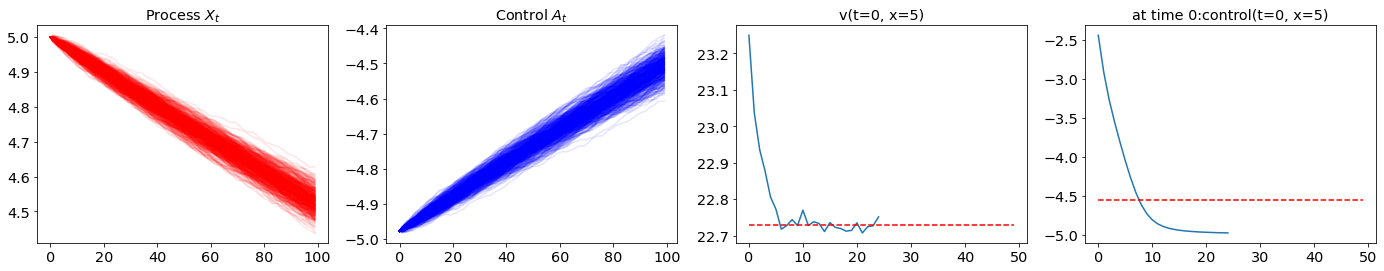

 50%|████████████████████▌                    | 250/500 [01:13<00:44,  5.68it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


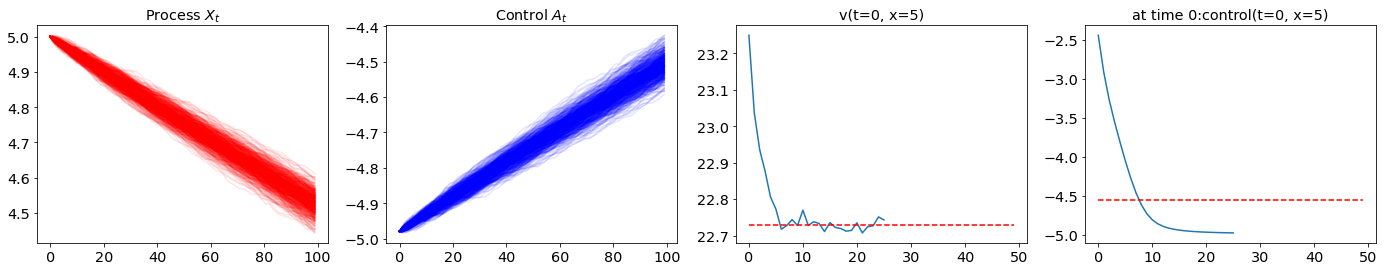

 52%|█████████████████████▎                   | 260/500 [01:16<00:42,  5.70it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


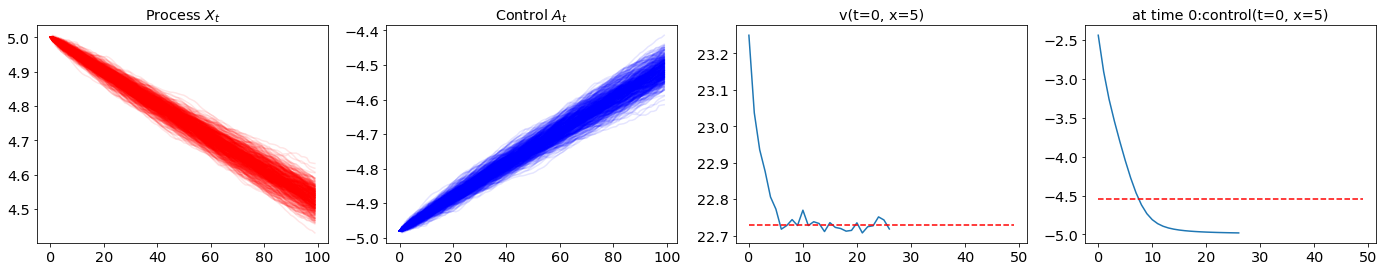

 54%|██████████████████████▏                  | 270/500 [01:19<00:43,  5.25it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


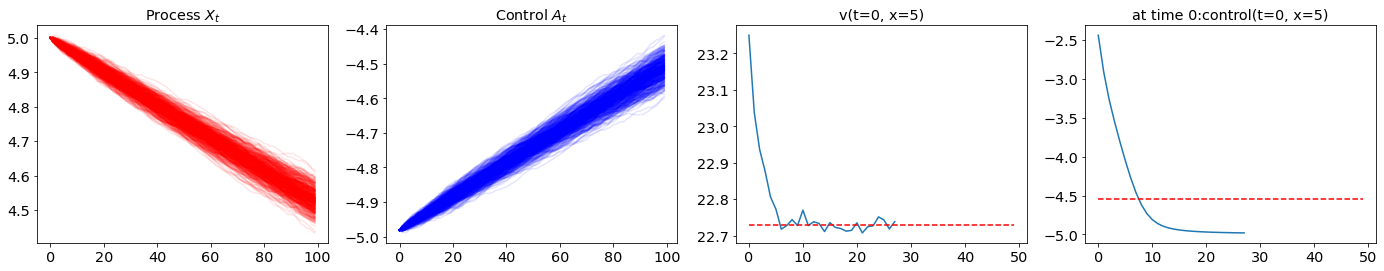

 56%|██████████████████████▉                  | 280/500 [01:22<00:42,  5.22it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


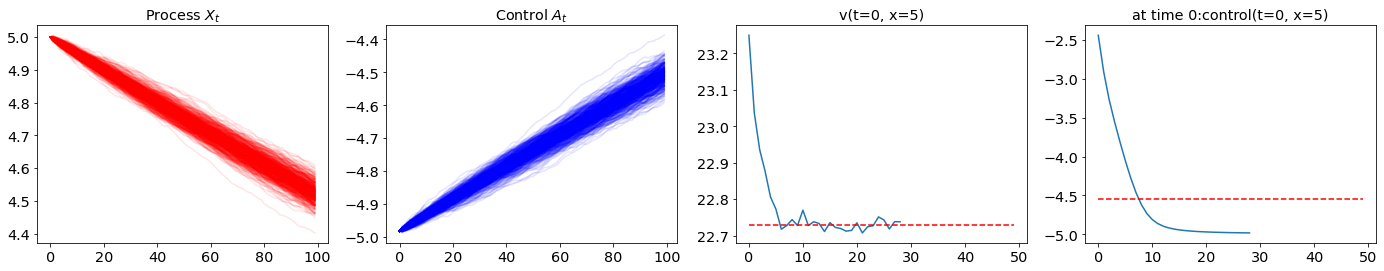

 58%|███████████████████████▊                 | 290/500 [01:25<00:36,  5.72it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


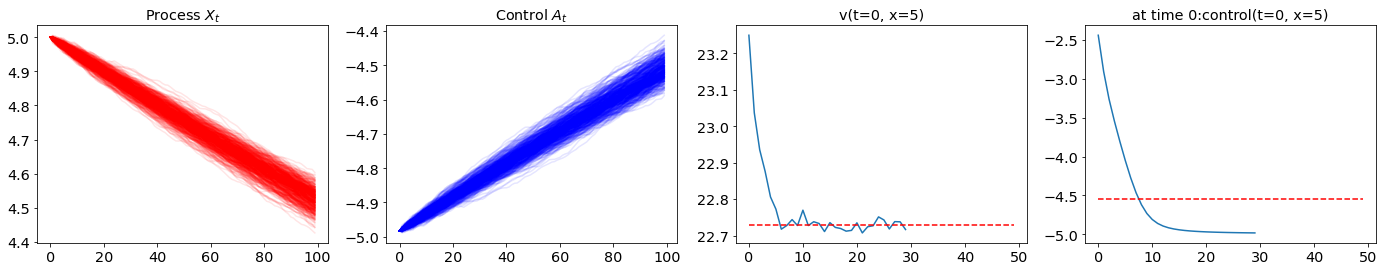

 60%|████████████████████████▌                | 300/500 [01:27<00:36,  5.47it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


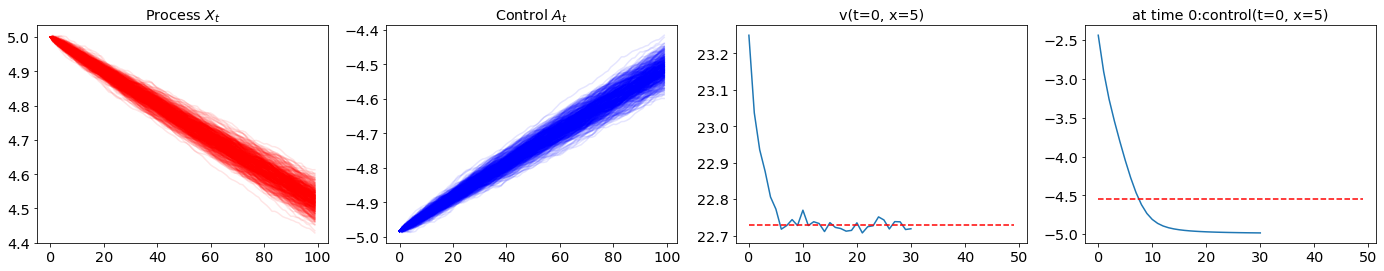

 62%|█████████████████████████▍               | 310/500 [01:30<00:34,  5.51it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


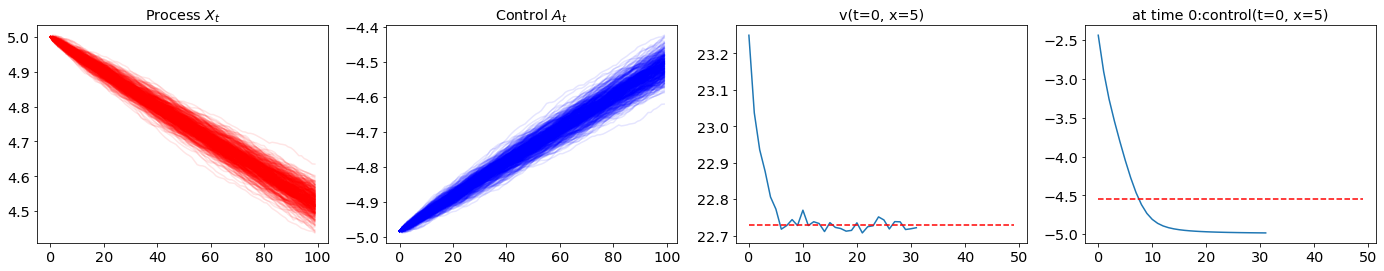

 64%|██████████████████████████▏              | 320/500 [01:33<00:33,  5.45it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


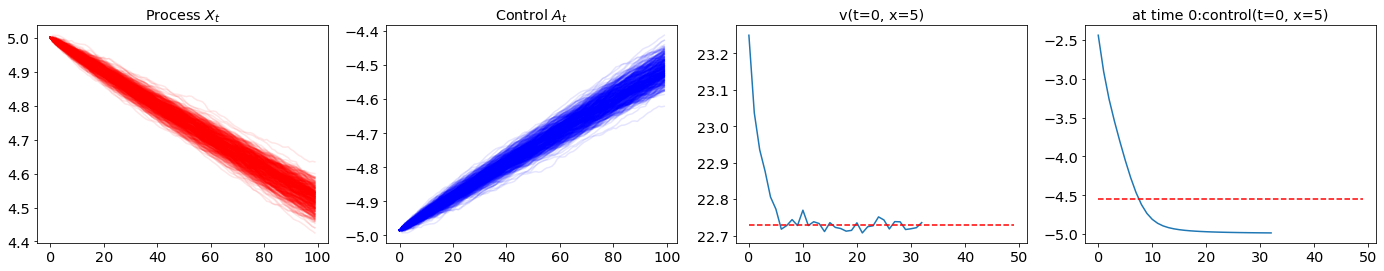

 66%|███████████████████████████              | 330/500 [01:36<00:30,  5.58it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


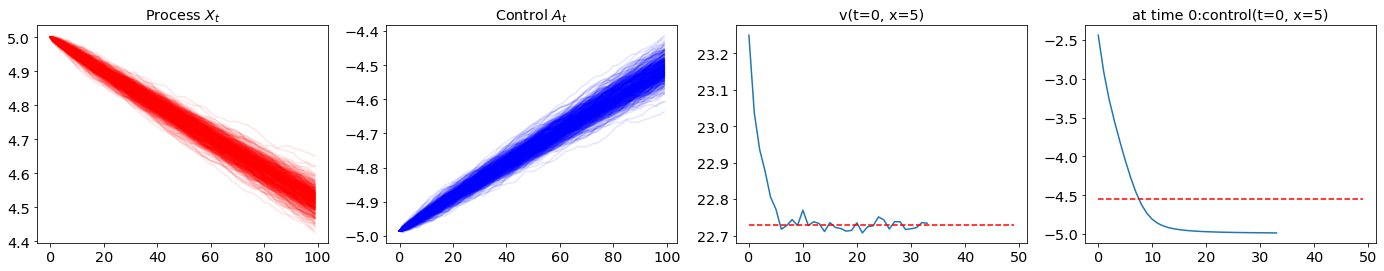

 68%|███████████████████████████▉             | 340/500 [01:39<00:28,  5.61it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


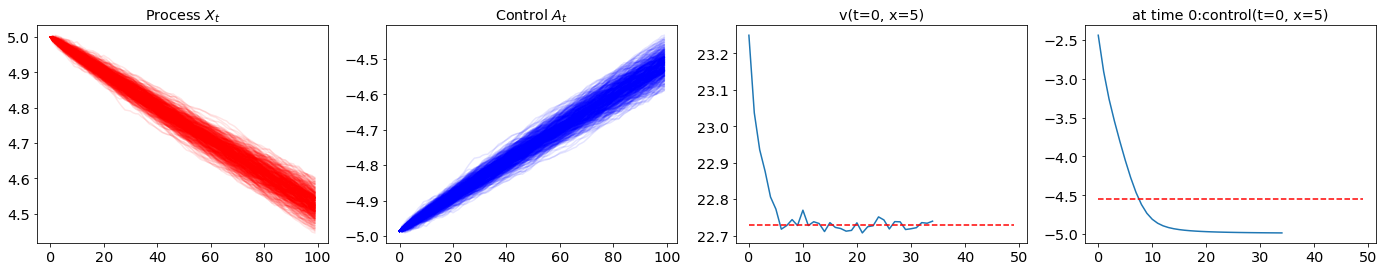

 70%|████████████████████████████▋            | 350/500 [01:42<00:26,  5.74it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


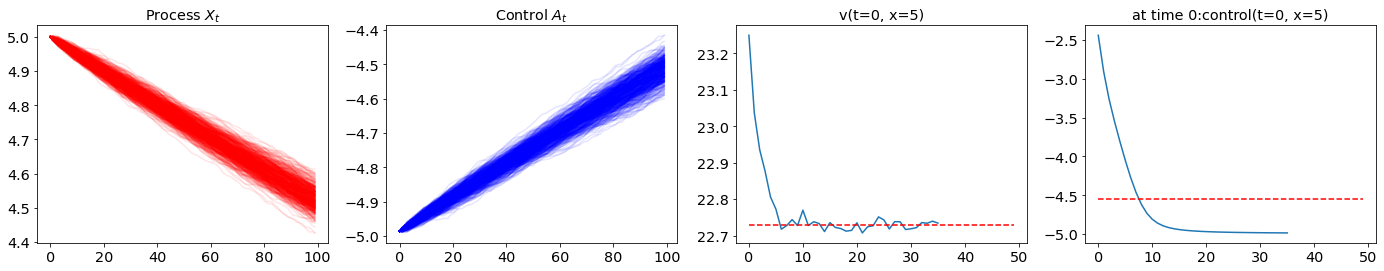

 72%|█████████████████████████████▌           | 360/500 [01:45<00:26,  5.35it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.75 
 theoretical optimal control at time 0: -4.55


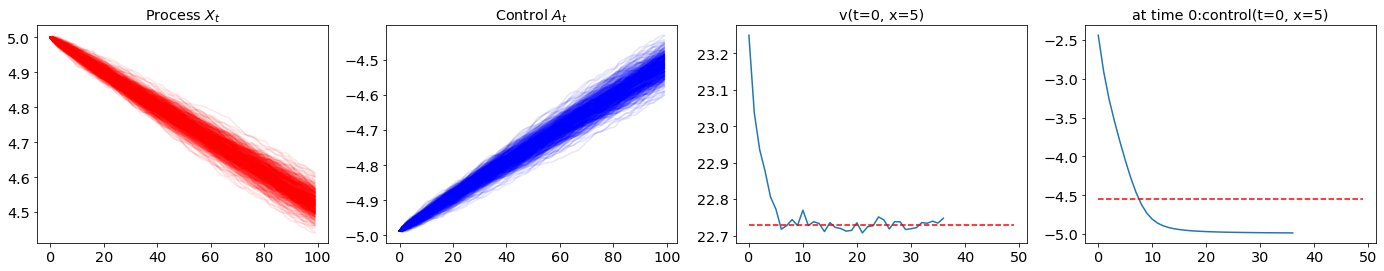

 74%|██████████████████████████████▎          | 370/500 [01:48<00:24,  5.27it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


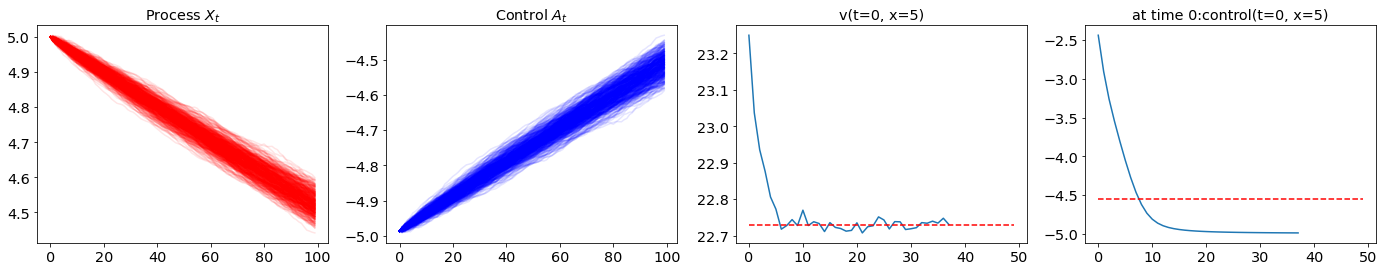

 76%|███████████████████████████████▏         | 380/500 [01:51<00:21,  5.56it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


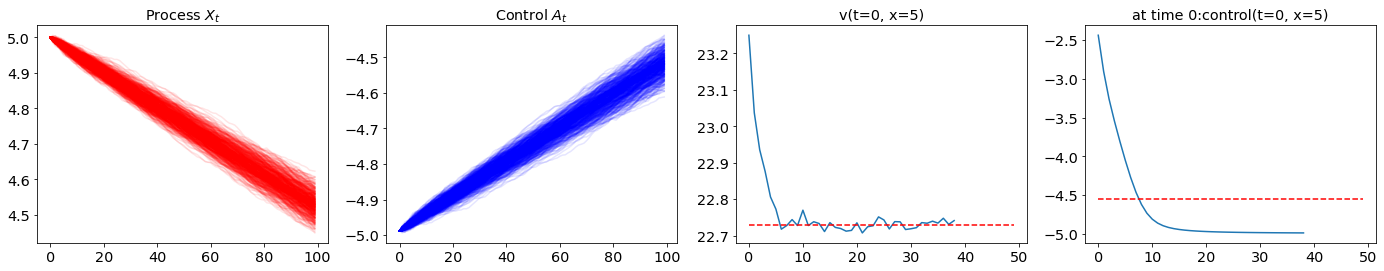

 78%|███████████████████████████████▉         | 390/500 [01:54<00:19,  5.64it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


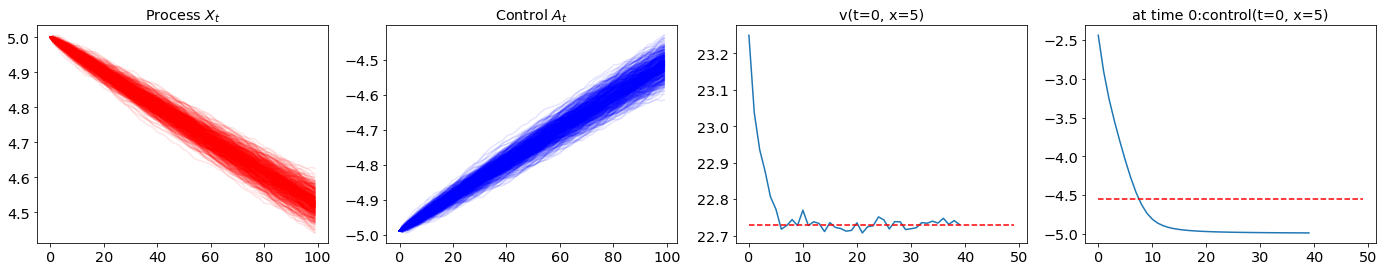

 80%|████████████████████████████████▊        | 400/500 [01:57<00:18,  5.51it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


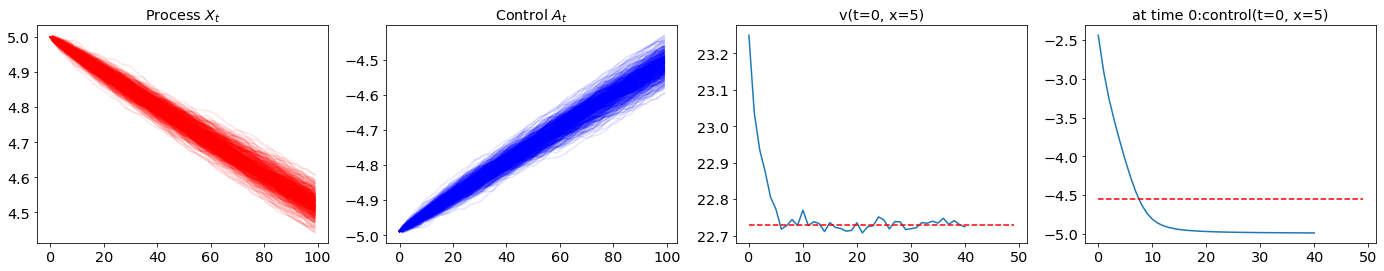

 82%|█████████████████████████████████▌       | 410/500 [01:59<00:16,  5.37it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.72 
 theoretical optimal control at time 0: -4.55


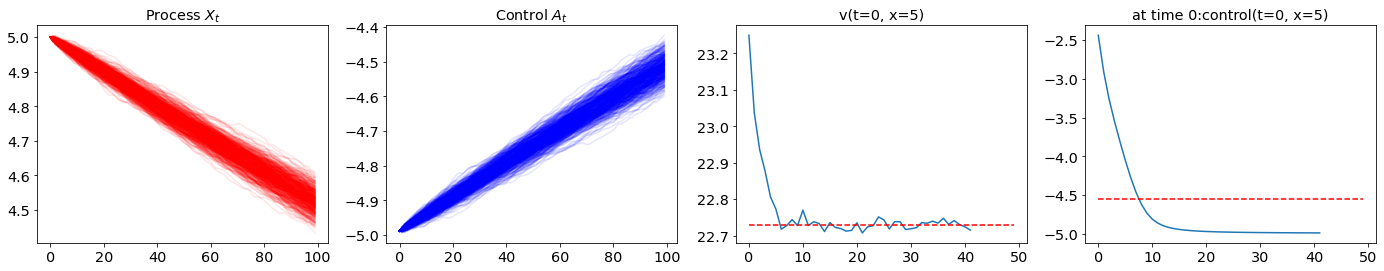

 84%|██████████████████████████████████▍      | 420/500 [02:02<00:14,  5.52it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


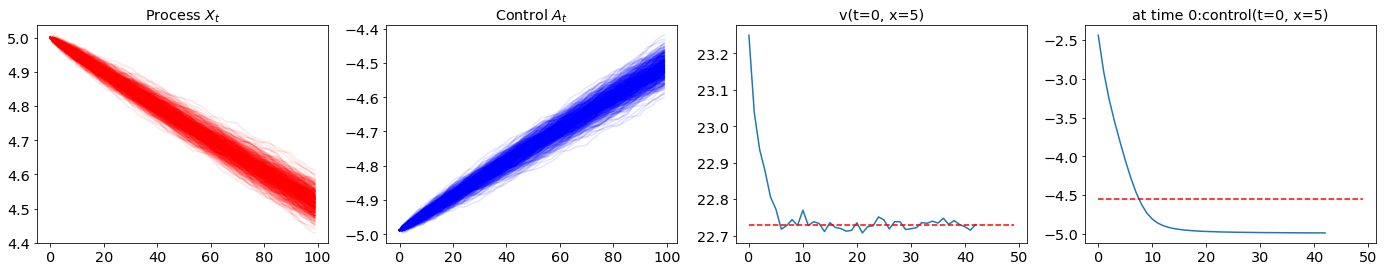

 86%|███████████████████████████████████▎     | 430/500 [02:05<00:12,  5.42it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


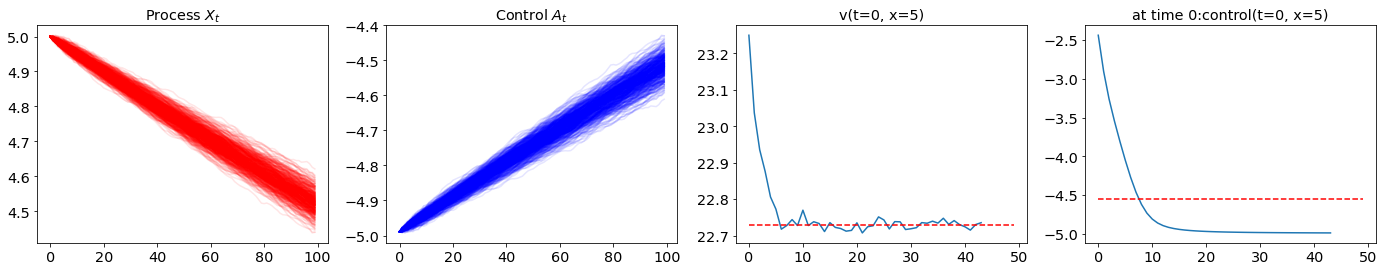

 88%|████████████████████████████████████     | 440/500 [02:08<00:11,  5.33it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.75 
 theoretical optimal control at time 0: -4.55


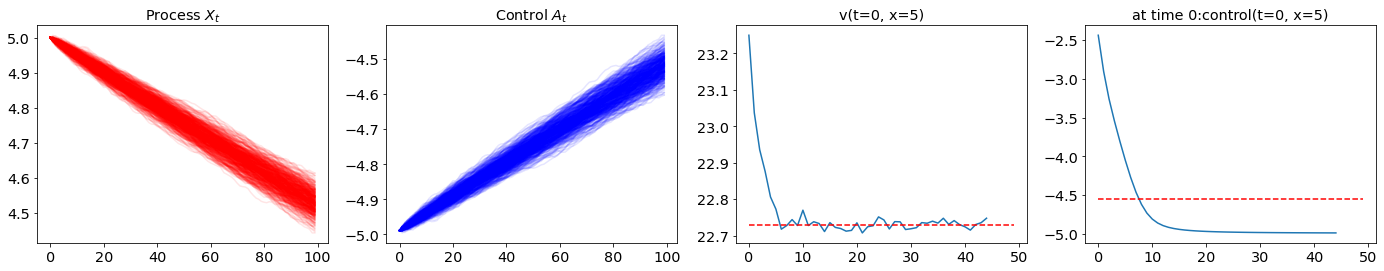

 90%|████████████████████████████████████▉    | 450/500 [02:11<00:08,  5.60it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


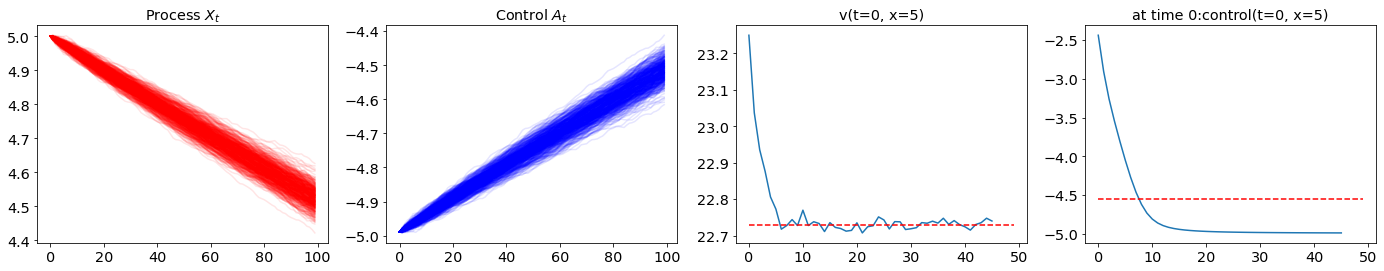

 92%|█████████████████████████████████████▋   | 460/500 [02:14<00:07,  5.43it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


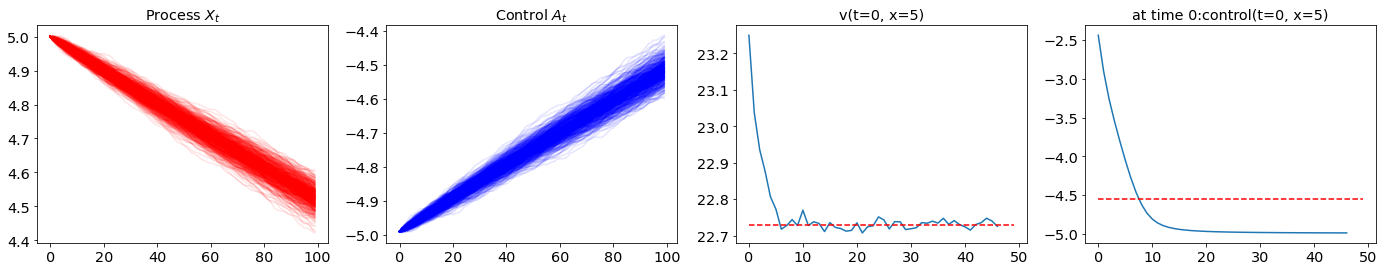

 94%|██████████████████████████████████████▌  | 470/500 [02:17<00:05,  5.31it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


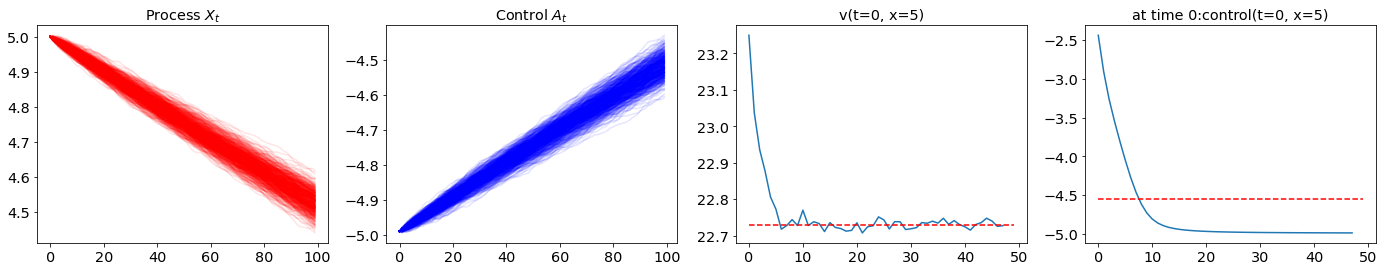

 96%|███████████████████████████████████████▎ | 480/500 [02:20<00:03,  5.62it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.74 
 theoretical optimal control at time 0: -4.55


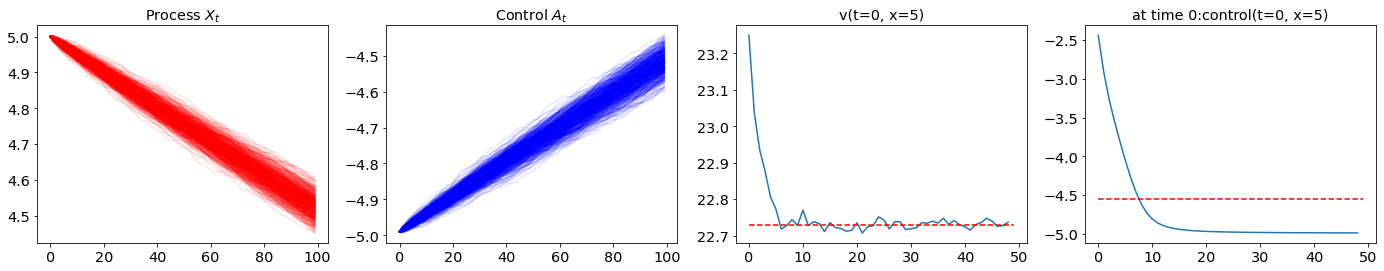

 98%|████████████████████████████████████████▏| 490/500 [02:23<00:01,  5.55it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.76 
 theoretical optimal control at time 0: -4.55


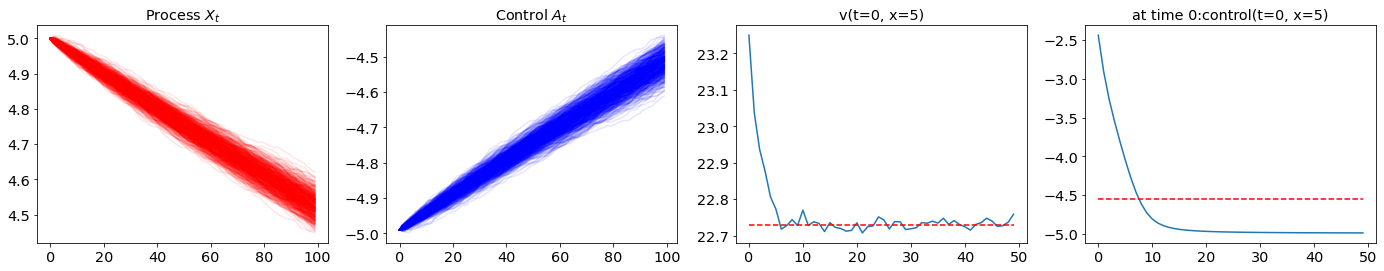

100%|████████████████████████████████████████▉| 499/500 [02:26<00:00,  5.43it/s]

 
 initial condition: 5 
 theoretical value function: 22.73 
 predicted value function: 22.73 
 theoretical optimal control at time 0: -4.55


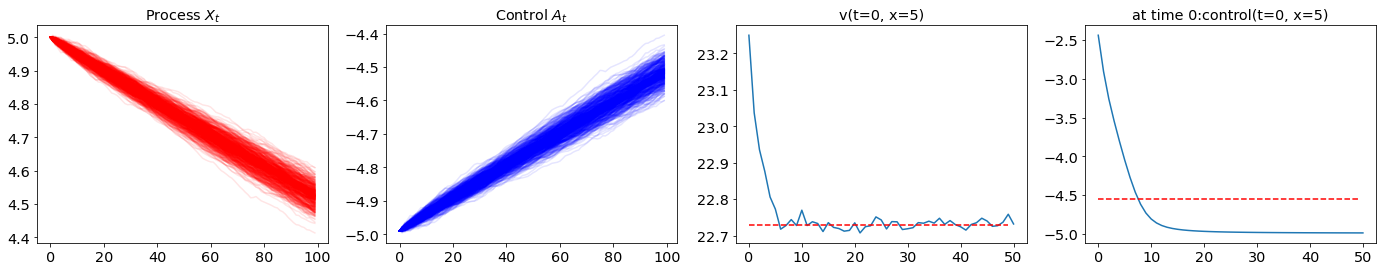

100%|█████████████████████████████████████████| 500/500 [02:27<00:00,  3.39it/s]


In [12]:
# training loop
trange = tqdm.tqdm(range(iterations))

for step in trange:

    # random initial condition
#     x0 = np.random.uniform(low=1.0, high=2.0)
    x0 = 5
    x0_batch = x0*torch.ones(batch_size, 1, device=device)

    optimiser.zero_grad()

    generated_samples = model(x0_batch, ts)

    t = ts.expand(batch_size, t_size).unsqueeze(2)


    x = generated_samples[...,0].unsqueeze(2)

    z = generated_samples[...,1:]
#     print(z[0,:,0])

    tz = torch.cat([t, z], dim=2)


#     alpha = model._func.h_theta(tz).clone().detach().requires_grad_(True)
    
    
    out_ = model._func.h_theta(tz)
    out_clone = out_.clone().detach()
    alpha = (out_clone[0,:,0]*x[0,:,0]).unsqueeze(1)
    alpha = torch.permute(alpha, (1,0))

    for i in range(1, batch_size):
      product_ = (out_clone[i,:,0]*x[i,:,0]).unsqueeze(1)
      product_ = torch.permute(product_, (1,0))
      alpha = torch.cat([alpha, product_], dim=0) 

    alpha = alpha.unsqueeze(2)
  
    the_integral = torch.tensor(0).repeat(batch_size, 1)[:,0].float()
    for i in range(t_size):
      the_integral += (T/t_size)*(Q_t*x[:,i,0]*x[:,i,0] + R_t*alpha[:,i,0]*alpha[:,i,0])
    
    
    # could be in multi-dimensional 

    x_T = x[:,-1,0]
    loss = torch.mean(Q_T*x_T*x_T + the_integral)

    loss.backward()

    optimiser.step()
    
    scheduler.step()

    if (step % iterations_per_print) == 0 or step == iterations - 1:
        with torch.no_grad():

            # random initial condition
            # x0 = np.random.uniform(low=1.0, high=2.0)

            # theoretical optimal control and value function v(t=0,x=x_0)
            v = x0**2*Q_T/(Q_T*T+1) + sigma**2*np.log(Q_T*T+1)
      
            # calculate the theoretical optimal control at time = 0
            # P_t_star = []
            # for i in range(T/dt):
            #   P_t_star.append(Q_T/(Q_T*(T-i*dt)+1))
            # P_t_star = np.array(P_t_star)  
            P_0_star = Q_T/(Q_T*T+1)          
            K_t_star = R_t*B_t*P_0_star
            a_0_star = -K_t_star * x0


            x0_batch = x0*torch.ones(batch_size, 1, device=device)

            generated_samples = model(x0_batch, ts)
            t = ts.expand(batch_size, t_size).unsqueeze(2)

            x = generated_samples[...,0].unsqueeze(2)
            z = generated_samples[...,1:]
            tz = torch.cat([t, z], dim=2)
            
#             alpha = model._func.h_theta(tz).cpu().numpy()
            
            out_ = model._func.h_theta(tz).cpu()

            alpha = (out_[0,:,0]*x[0,:,0]).unsqueeze(1)
            alpha = torch.permute(alpha, (1,0))

            for i in range(1, batch_size):
              product_ = (out_[i,:,0]*x[i,:,0]).unsqueeze(1)
              product_ = torch.permute(product_, (1,0))
              alpha = torch.cat([alpha, product_], dim=0) 

            alpha = alpha.unsqueeze(2)
            
            x_T = x[:,-1]
            the_integral = 0

            for i in range(t_size):
              the_integral += (T/t_size)*(Q_t*x[:,i,0]*x[:,i,0] + R_t*alpha[:,i,0]*alpha[:,i,0])
            
        
            
            # could be in multi-dimensional 
            loss = torch.mean(Q_T*x_T*x_T + the_integral)
#             print(alpha)
#             print(loss)
            v_theo = np.round(v,2)
            a_theo = np.round(a_0_star,2)

            # print the two theoretical solution line
            v_list = []
            a_list = []
            for i in range(times):
                v_list.append(v_theo)
                a_list.append(a_theo)
            
            print(f' \n initial condition: {np.round(x0,2)} \n',
                  f'theoretical value function: {v_theo} \n', 
                  f'predicted value function: {np.round(loss.cpu().numpy().item(),2)} \n',
                  f'theoretical optimal control at time 0: {a_theo}'
                  )
            alpha_0 = torch.mean(alpha[:,0])
            losses.append(loss)
            controls.append(alpha_0)

            results_plot(model, x0_batch, losses, controls, T, batch_size, t_size_test, v_list, a_list, times)

In [13]:
controls

[tensor(-2.4373),
 tensor(-2.9052),
 tensor(-3.2604),
 tensor(-3.5459),
 tensor(-3.8052),
 tensor(-4.0491),
 tensor(-4.2724),
 tensor(-4.4656),
 tensor(-4.6199),
 tensor(-4.7330),
 tensor(-4.8103),
 tensor(-4.8612),
 tensor(-4.8946),
 tensor(-4.9169),
 tensor(-4.9324),
 tensor(-4.9435),
 tensor(-4.9517),
 tensor(-4.9579),
 tensor(-4.9628),
 tensor(-4.9667),
 tensor(-4.9699),
 tensor(-4.9725),
 tensor(-4.9746),
 tensor(-4.9765),
 tensor(-4.9780),
 tensor(-4.9794),
 tensor(-4.9805),
 tensor(-4.9816),
 tensor(-4.9825),
 tensor(-4.9833),
 tensor(-4.9840),
 tensor(-4.9846),
 tensor(-4.9852),
 tensor(-4.9857),
 tensor(-4.9862),
 tensor(-4.9866),
 tensor(-4.9870),
 tensor(-4.9873),
 tensor(-4.9876),
 tensor(-4.9879),
 tensor(-4.9882),
 tensor(-4.9885),
 tensor(-4.9887),
 tensor(-4.9889),
 tensor(-4.9891),
 tensor(-4.9893),
 tensor(-4.9895),
 tensor(-4.9896),
 tensor(-4.9898),
 tensor(-4.9899),
 tensor(-4.9901)]

In [14]:
dadasa.a

In [15]:
import pandas as pd
# change data type to float
controls_ = list(map(float,controls))
losses_ = list(map(float,losses))
#use pandas
# #write date by using the form of dict
# data_controls = pd.DataFrame(controls_)
# data_controls.to_csv("test1.csv",index=False)
# # loss
# data_losses = pd.DataFrame(losses_)
# data_losses.to_csv("test2.csv",index=False)

In [16]:
# # 导入CSV模块
# import csv
# # first time write data in csv.
 
# # 1. 创建文件对象（指定文件名，模式，编码方式）
# # with open("test1.csv", "w", encoding="gbk", newline="") as f:
# with open("2_p1_controls.csv", "w") as f:
#     # 2. 基于文件对象构建 csv写入对象
#     csv_writer = csv.writer(f)
# #     # 3. 构建列表头
#     csv_writer.writerow(range(1,52))
#     # 4. 写入csv文件内容
#     csv_writer.writerow(controls_)
#     print("data save successful")
#     # 5. 关闭文件
#     f.close()
    
# # 1. 创建文件对象（指定文件名，模式，编码方式）
# # with open("test1.csv", "w", encoding="gbk", newline="") as f:
# with open("2_p1_losses.csv", "w") as f:
#     # 2. 基于文件对象构建 csv写入对象
#     csv_writer = csv.writer(f)
#     # 3. 构建列表头
#     csv_writer.writerow(range(1,52))
#     # 4. 写入csv文件内容
#     csv_writer.writerow(losses_)
#     print("data save successful")
#     # 5. 关闭文件
#     f.close()



In [17]:
# 导入CSV模块
import csv
# write new data
 
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("test1.csv", "a", encoding="gbk", newline="") as f:
with open("2_p1_controls.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,52))
    # 4. 写入csv文件内容
    csv_writer.writerow(controls_)
    print("data save successful")
    # 5. 关闭文件
    f.close()
    
# 1. 创建文件对象（指定文件名，模式，编码方式）
# with open("test1.csv", "a", encoding="gbk", newline="") as f:
with open("2_p1_losses.csv", "a") as f:
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
#     csv_writer.writerow(range(1,52))
    # 4. 写入csv文件内容
    csv_writer.writerow(losses_)
    print("data save successful")
    # 5. 关闭文件
    f.close()




data save successful
data save successful


In [18]:
reader_controls = pd.read_csv("2_p1_controls.csv")
reader_losses = pd.read_csv("2_p1_losses.csv")
reader_controls

ParserError: Error tokenizing data. C error: Expected 56 fields in line 52, saw 106


In [ ]:
reader_losses